# Bike Sharing with Deep Learning
## Contributors
- Filipe Gonçalves, 98083, MRSI

## Context
A bikesharing business consists in creating a system which lets a user rent and use a bicycle as its own for a small period of time.
However, the companies who invest in these types of business, can't gain much with just the system and services, they also need to promote the services and understand the most viable places to place the anchors, which are used to recharge the bikes or just save them, and which routes should be best for a user to take as to pass by some promoted caffes / restaurants / etc.


## Dataset Refactoring

### Imports

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import requests
import json
from pathlib import Path
import polyline
import random

### Read Data
We need to read the data from each month as to predict seasonally what the best places will be and which places are getting more attention as the years pass.

Each trip has a lot of different features which can be usefull to us, and some which can be discarded easily.

In [9]:
filename = "./Dataset/202010-capitalbikeshare-tripdata/202010-capitalbikeshare-tripdata.csv"
data = pd.read_csv(filename)
data = data.dropna()
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,3A8C551C68AD3676,docked_bike,2020-10-09 16:44:38,2020-10-09 17:55:57,Constitution Ave & 2nd St NW/DOL,305.0,USDA / 12th & C St SW,117.0,38.892275,-77.013917,38.886277,-77.028242,casual
1,BF72D49088F26637,docked_bike,2020-10-31 09:27:31,2020-10-31 09:38:32,8th & O St NW,413.0,Jefferson Dr & 14th St SW,185.0,38.908640,-77.022770,38.888553,-77.032427,member
2,3F1B0E9624087288,docked_bike,2020-10-28 17:11:50,2020-10-28 17:21:07,8th & O St NW,413.0,15th St & Constitution Ave NW,531.0,38.908640,-77.022770,38.892244,-77.033234,member
3,F96BDE7A4EC2BA19,docked_bike,2020-10-11 11:23:02,2020-10-11 11:46:18,Massachusetts Ave & Dupont Circle NW,24.0,5th & F St NW,141.0,38.910100,-77.044400,38.897222,-77.019347,member
4,2472C0AE0A0CE012,docked_bike,2020-10-20 13:32:51,2020-10-20 14:00:59,Henry Bacon Dr & Lincoln Memorial Circle NW,452.0,Jefferson Dr & 14th St SW,185.0,38.890539,-77.049383,38.888553,-77.032427,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
229791,62E64B964B60B718,docked_bike,2020-10-14 16:34:15,2020-10-14 17:22:07,Anacostia Ave & Benning Rd NE / River Terrace,43.0,Anacostia Ave & Benning Rd NE / River Terrace,43.0,38.896544,-76.960120,38.896544,-76.960120,casual
229792,313F1242C40DB408,docked_bike,2020-10-02 19:11:09,2020-10-02 19:30:35,1st & M St NE,65.0,10th & Monroe St NE,59.0,38.905697,-77.005483,38.932514,-76.992889,member
229793,11D0589008C626B6,docked_bike,2020-10-09 11:32:47,2020-10-09 13:02:48,National Harbor Carousel,647.0,Lincoln Memorial,277.0,38.785900,-77.016700,38.888255,-77.049437,casual
229794,D52C7FA0023CFCE4,docked_bike,2020-10-24 16:11:06,2020-10-24 18:07:59,15th St & Constitution Ave NW,531.0,Henry Bacon Dr & Lincoln Memorial Circle NW,452.0,38.892244,-77.033234,38.890539,-77.049383,casual


### Get All Stations
After the data is retrieved, we need to get a full and unique list of all the possible stations.

Each station has its ID, name, latitude and longitude.

In [10]:
stations_start = data[['start_station_id','start_station_name','start_lat','start_lng']].copy()
stations_start.rename(
    columns={"start_station_id": "ID", "start_station_name": "Name", "start_lat": "Lat", "start_lng": "Lng"},
    inplace=True )

stations_end = data[['end_station_id','end_station_name','end_lat','end_lng']].copy()
stations_end.rename(
    columns={"end_station_id": "ID", "end_station_name": "Name", "end_lat": "Lat", "end_lng": "Lng"},
    inplace=True )

stations = pd.concat(objs=[stations_start, stations_end])
stations = stations.sort_values(by="ID").drop_duplicates(subset=['ID']).reset_index().drop(columns=["index"])
stations

,ID,Name,Lat,Lng
0,1.0,Eads St & 15th St S,38.858971,-77.053230
1,2.0,18th St & S Eads St,38.857227,-77.053737
2,3.0,Crystal Dr & 20th St S,38.856425,-77.049232
3,4.0,Crystal Dr & 15th St S,38.860170,-77.049593
4,5.0,Aurora Hills Cmty Ctr / 18th St & S Hayes St,38.857866,-77.059490
...,...,...,...,...
603,681.0,13th & U St NW,38.916936,-77.029631
604,682.0,Stadium Armory Metro,38.885596,-76.977149
605,683.0,Broad Branch Rd & Northampton St NW,38.965774,-77.068626
606,684.0,St. Asaph & Montgomery St,38.814185,-77.043809


### Change IDs in All Rides
While its good to have an ID for each ride, we need to create a specific ID for each bike.

In a perfect world, we will have 10 docks for each stations, and there should be 2 docks for each bike, as to always have space for a bike to end its travel. As such, we will have the number of stations times 5, number of bikes, and we can simulate which bike did which ride with a simple randomizer.

In [11]:
rides = data[['ride_id', 'rideable_type']].copy()

rides.rename(
    columns={'ride_id': 'ID', 'rideable_type': 'ride_type'},
    inplace=True )

rides = rides.sort_values(by='ID').drop_duplicates(subset=['ID']).reset_index().drop(columns=["index"])

NUM_BIKES = len(stations) * 5           # 1 estacao tem 10 docas e devem haver 2 docas por bike

all_bikes = list(range(NUM_BIKES))

bikes_temp = [all_bikes[random.randint(0,NUM_BIKES-1)] for ride in rides.values]

data.insert(13, "bikeID", bikes_temp, True)
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,bikeID
0,3A8C551C68AD3676,docked_bike,2020-10-09 16:44:38,2020-10-09 17:55:57,Constitution Ave & 2nd St NW/DOL,305.0,USDA / 12th & C St SW,117.0,38.892275,-77.013917,38.886277,-77.028242,casual,1208
1,BF72D49088F26637,docked_bike,2020-10-31 09:27:31,2020-10-31 09:38:32,8th & O St NW,413.0,Jefferson Dr & 14th St SW,185.0,38.908640,-77.022770,38.888553,-77.032427,member,319
2,3F1B0E9624087288,docked_bike,2020-10-28 17:11:50,2020-10-28 17:21:07,8th & O St NW,413.0,15th St & Constitution Ave NW,531.0,38.908640,-77.022770,38.892244,-77.033234,member,1481
3,F96BDE7A4EC2BA19,docked_bike,2020-10-11 11:23:02,2020-10-11 11:46:18,Massachusetts Ave & Dupont Circle NW,24.0,5th & F St NW,141.0,38.910100,-77.044400,38.897222,-77.019347,member,1959
4,2472C0AE0A0CE012,docked_bike,2020-10-20 13:32:51,2020-10-20 14:00:59,Henry Bacon Dr & Lincoln Memorial Circle NW,452.0,Jefferson Dr & 14th St SW,185.0,38.890539,-77.049383,38.888553,-77.032427,casual,385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229791,62E64B964B60B718,docked_bike,2020-10-14 16:34:15,2020-10-14 17:22:07,Anacostia Ave & Benning Rd NE / River Terrace,43.0,Anacostia Ave & Benning Rd NE / River Terrace,43.0,38.896544,-76.960120,38.896544,-76.960120,casual,2723
229792,313F1242C40DB408,docked_bike,2020-10-02 19:11:09,2020-10-02 19:30:35,1st & M St NE,65.0,10th & Monroe St NE,59.0,38.905697,-77.005483,38.932514,-76.992889,member,1108
229793,11D0589008C626B6,docked_bike,2020-10-09 11:32:47,2020-10-09 13:02:48,National Harbor Carousel,647.0,Lincoln Memorial,277.0,38.785900,-77.016700,38.888255,-77.049437,casual,2221
229794,D52C7FA0023CFCE4,docked_bike,2020-10-24 16:11:06,2020-10-24 18:07:59,15th St & Constitution Ave NW,531.0,Henry Bacon Dr & Lincoln Memorial Circle NW,452.0,38.892244,-77.033234,38.890539,-77.049383,casual,36


### Plot Most Used Docks
For each month, we can see which stations are the most used by simply counting the number of times it was used, both for starting a trip as well as ending one.

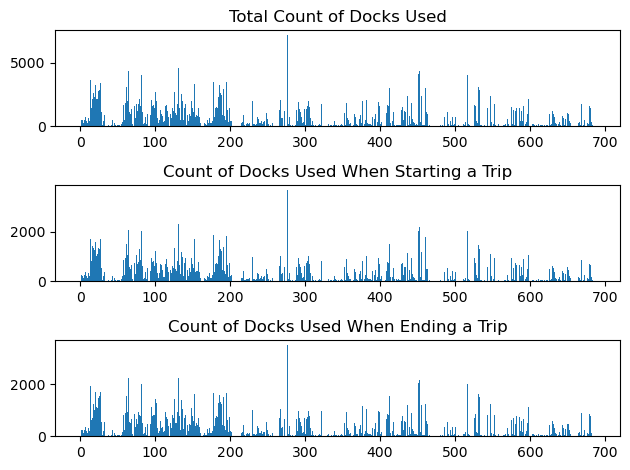

In [12]:
count_stations = {}
start_stations = {}
end_stations = {}

for trip in data.values:
    # general count
    if trip[5] in count_stations.keys():
        count_stations[trip[5]] += 1
    else:
        count_stations[trip[5]] = 1

    if trip[7] in count_stations.keys():
        count_stations[trip[7]] += 1
    else:
        count_stations[trip[7]] = 1

    # start stations
    if trip[5] in start_stations.keys():
        start_stations[trip[5]] += 1
    else:
        start_stations[trip[5]] = 1

    # end stations
    if trip[7] in end_stations.keys():
        end_stations[trip[7]] += 1
    else:
        end_stations[trip[7]] = 1


fig, axs = plt.subplots(3)

axs[0].hist(list(count_stations.keys()), len(count_stations), weights=list(count_stations.values()))
axs[0].set_title("Total Count of Docks Used")

axs[1].hist(list(start_stations.keys()), len(start_stations), weights=list(start_stations.values()))
axs[1].set_title("Count of Docks Used When Starting a Trip")

axs[2].hist(list(end_stations.keys()), len(end_stations), weights=list(end_stations.values()))
axs[2].set_title("Count of Docks Used When Ending a Trip")

fig.tight_layout()

### Create Unlock, Lock and KeepAlive Messages
As the main project dictates, each trip contains an Unlock Message, a Lock Message and a lot of KeepAlive Messages which should be sent every five seconds, but in this case, will be sent with unpredictable time spans.

The Unlock and Lock Messages contains the ID of the bike, the ID of the station and the Timestamp at which the message was sent.

The KeepAlive Message contains the ID of the bike, Latitude and Longitude of the bike at the current time, and the Timestamp at which the message was sent.

In [13]:
unlock_temp = []
lock_temp = []
keepalive_temp = []

intersections = []

for trip in data.values[:5000]:
    bikeID = trip[13]

    # unlock message
    unlock_dockID = trip[5]
    unlock_timestamp = datetime.strptime(trip[2], '%Y-%m-%d %H:%M:%S').timestamp()
    unlock_message = {"BikeID": bikeID, "DockID": unlock_dockID, "Timestamp": unlock_timestamp}
    
    # lock messageTim
    lock_dockID = trip[7]
    lock_timestamp = datetime.strptime(trip[3], '%Y-%m-%d %H:%M:%S').timestamp()
    lock_message = {"BikeID": bikeID, "DockID": lock_dockID, "Timestamp": lock_timestamp}

    # keepalive messages
    start = stations.loc[stations["ID"] == unlock_dockID]
    end = stations.loc[stations["ID"] == lock_dockID]
    lat_start = str(start.iloc[0]["Lat"])
    lng_start = str(start.iloc[0]["Lng"])
    lat_end = str(end.iloc[0]["Lat"])
    lng_end = str(end.iloc[0]["Lng"])

    timestamp = datetime.strptime(trip[2], '%Y-%m-%d %H:%M:%S').timestamp()

    duration = datetime.strptime(trip[3], '%Y-%m-%d %H:%M:%S').timestamp() - timestamp

    response = requests.get(f"http://localhost:3000/directions/coordinates?start=13.388860,52.517037&end=13.428555,52.523219")
    points = json.loads(response.content.decode("utf-8"))

    for keepalive in points:
        longitude, latitude = keepalive
        timestamp = duration/len(points) + timestamp
        keepalive_message = {"BikeID": bikeID, "Latitude": latitude, "Longitude": longitude, "Timestamp": int(timestamp)}
        keepalive_temp.append(keepalive_message)

    unlock_temp.append(unlock_message)
    lock_temp.append(lock_message)

unlock = pd.DataFrame(unlock_temp, columns=["BikeID", "DockID", "Timestamp"])
lock = pd.DataFrame(lock_temp, columns=["BikeID", "DockID", "Timestamp"])
keepalive = pd.DataFrame(keepalive_temp, columns=["BikeID", "Latitude", "Longitude", "Timestamp"])

ConnectionError: HTTPConnectionPool(host='localhost', port=3000): Max retries exceeded with url: /directions/coordinates?start=13.388860,52.517037&end=13.428555,52.523219 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fa06368e8b0>: Failed to establish a new connection: [Errno 111] Connection refused'))

### Save DataFrames to CSV

In [ ]:
stations_filepath = Path('./RefactoredDatasets/stations202010.csv')
stations_filepath.parent.mkdir(parents=True, exist_ok=True)  
stations.to_csv(stations_filepath)

unlock_filepath = Path('./RefactoredDatasets/unlock202010.csv')
unlock_filepath.parent.mkdir(parents=True, exist_ok=True)  
unlock.to_csv(unlock_filepath)

lock_filepath = Path('./RefactoredDatasets/lock202010.csv')
lock_filepath.parent.mkdir(parents=True, exist_ok=True)  
lock.to_csv(lock_filepath)

keepalive_filepath = Path('./RefactoredDatasets/keepalive202010.csv')
keepalive_filepath.parent.mkdir(parents=True, exist_ok=True)  
keepalive.to_csv(keepalive_filepath)

with open("intersections.json", "w") as f:
    f.write(json.dumps({'intersections': intersections}))

### Bikes in Docks

In [14]:
bikesPerDock_temp = [({int(x[0]): 10 for x in stations.values}, datetime.strptime(data.values[0][2], '%Y-%m-%d %H:%M:%S').timestamp()-1, datetime.strptime(data.values[0][2], '%Y-%m-%d %H:%M:%S').timetuple().tm_yday)]

for trip in data.values[:10000]:
    bikeID = trip[13]

    # unlock
    unlock_dockID = trip[5]
    unlocks = datetime.strptime(trip[2], '%Y-%m-%d %H:%M:%S')
    unlock_timestamp = unlocks.timestamp()
    
    # lock
    lock_dockID = trip[7]
    locks = datetime.strptime(trip[3], '%Y-%m-%d %H:%M:%S')
    lock_timestamp = locks.timestamp()

    last = bikesPerDock_temp[-1][0].copy()

    last[unlock_dockID] -= 1
    last[lock_dockID] += 1
    if last[unlock_dockID] < 0 or last[lock_dockID] > 15:
        continue

    bikesPerDock_temp.append(({int(x[0]): last[int(x[0])] for x in stations.values}, unlock_timestamp, unlocks.timetuple().tm_yday))
    bikesPerDock_temp.append(({int(x[0]): last[int(x[0])] for x in stations.values}, lock_timestamp, locks.timetuple().tm_yday))

bikesPerDock = [{"Docks": x[0], "Time": x[1], "Day": x[2]} for x in bikesPerDock_temp]
bikesDock = pd.DataFrame(bikesPerDock, columns=["Docks", "Time", "Day"]).sort_values(by="Day")

filepath = Path('./bikesPerDocks.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)  
bikesDock.to_csv(filepath)

In [30]:
bikesDock.sort_values(by="Day")
day300 = bikesDock[bikesDock["Day"] == 300]

count = len(day300.values)

average = {}
for day in day300.values:
    docks = day[0]
    for dock in docks:
        if dock in average.keys():
            average[dock] += docks[dock] / count
        else:
            average[dock] = docks[dock] / count

useful_docks = {}
for dock in average:
    if average[dock] > 13 or average[dock] < 5:
        useful_docks[dock] = average[dock]

len(useful_docks)

50